<a href="https://colab.research.google.com/github/alecveda-wq/PytLab/blob/main/Copy_of_Week_4_Workalong.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Week 4 - AI


We are going to spend the time this week working on how we can use AI in Colab.

Before we click the _Run_ button on our cell we are going to need to **switch our runtime** so that we are using one that has some AI hardware support.

Under your picture there is a drop down arrow next to _Connect_. Click on that and select _Change runtime type_ and select _T4 GPU_.

Basically AI tools do the same kind of math that graphics cards do, so you if you use a graphics card you can get results much faster.

## Transformers Library

Transformers is a Python Library provided by [hugging face](https://huggingface.co/) which is a platform that hosts a collective of generative AI tools. We could probably spend all 4 weeks of this class exploring it but we are just going to try a few things.

## Summarzing PDFs

In week 3 we did some text analysis on a collection of PDFs. We are going to use those same files. The next cell will install all the libraries that we need to do this using AI.

**Please note** The next cell will take a least a couple of minutes to run! It took 2 minutes for me!

In [11]:
# install these libraries since they aren't available be default
!pip install pypdf
!pip install transformers

#Colab has a special library just for working with files on google drive
from google.colab import drive

from pypdf import PdfReader
import pandas as pd
import glob
import shutil

#Let's ignore the pypdf errors
import warnings
warnings.filterwarnings('ignore')

#this is the new transformers stuff
from transformers import BartTokenizer, BartForConditionalGeneration # Import BartTokenizer and BartForConditionalGeneration

#Mount Google Drive
drive.mount('/content/gdrive')


print("Libraries and Data loaded!")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
Libraries and Data loaded!



## The Model

We'll be using [bart-large-cnn](https://huggingface.co/facebook/bart-large-cnn) to do the summaries with the transformers library. I won't explain the code line by line. This is a bit 'hand-wavy' I realize but there is plenty of material online that will help you understand what *exactly* is going on here if you are curious.

Basically what we are doing is downloading components of a large language model (gigabytes worth) that has been pretrained and we are creating a function that when given text, returns a summary of that text.

In [12]:
# Setup our pieces (this will also take some time)
tokenizer = BartTokenizer.from_pretrained('facebook/bart-large-cnn')
model = BartForConditionalGeneration.from_pretrained('facebook/bart-large-cnn')

#We'll create a function that does the summary
def generate_summary(text):
    inputs = tokenizer.encode("summarize: " + text, return_tensors="pt", max_length=1024, truncation=True)
    summary_ids = model.generate(inputs, max_length=150, min_length=50, length_penalty=2.0, num_beams=4, early_stopping=True)
    summary = tokenizer.decode(summary_ids[0], skip_special_tokens=True)
    return summary


## Summarize each file

We'll now loop through each PDF in our `LibraryJuicePython` directory, extract the text, and then create a dataframe of those summaries.


This cell will probably take a long time to run, especially if you have a lot of PDF files. _Like minutes worth of waiting!_ Seriously you should probably grab a coffee.

In [13]:
summaries = []

for file in glob.glob("/content/gdrive/MyDrive/LibraryJuicePython/*.pdf"):

  filename = file.split("/")[-1]
  print("Generating Summary for... ",filename)
  text = ""
  reader = PdfReader(file)
  for page in reader.pages:
    text += page.extract_text()

  #call our newly made function
  summary = generate_summary(text)
  summaries.append([filename,summary])

#Turn our summaries into a dataframe.
summary_data = pd.DataFrame(summaries)
summary_data.columns = ["Filename","Summary"]
print("Finished!")

Generating Summary for...  Ballerina review.pdf
Generating Summary for...  Ballerina review2.pdf
Generating Summary for...  Ballerina Review3.pdf
Generating Summary for...  Ballerina review 4.pdf
Generating Summary for...  Ballerina review 5.pdf
Generating Summary for...  Ballerina review 6.pdf
Finished!


In [14]:
#Let's look at our final dataframe
summary_data

,Filename,Summary
0,Ballerina review.pdf,Lionsgate stretches the John Wick franchise ju...
1,Ballerina review2.pdf,Ballerina checks every box of a John Wick film...
2,Ballerina Review3.pdf,Ballerina is shockingly really good. The scene...
3,Ballerina review 4.pdf,Get ready for plenty of fighting and gunfight ...
4,Ballerina review 5.pdf,“Ballerina” is a halfway decent action movie t...
5,Ballerina review 6.pdf,"“Ballerina” is a stylish, entertaining, and su..."


In [15]:
#Let's now save this summary information in our directory as a CSV file
summary_data.to_csv("/content/gdrive/MyDrive/LibraryJuicePython/adv_week4_pdf_summaries.csv", index=False)


# You can stop here!

I've asked you to be pretty patient while you watch code running. Feel free to finish the notebook here. The next section is not necessary but more for fun.



## AI for image generation

The first activity for this week was, let's say interesting, but dense in code. Let's just finish off by having some fun with image generation.

This is another cell that will take a bit to run. Go grab another coffee I'd say. All the bars will need to turn green before it is done. Usually this cell will take 5 minutes to load.

In [16]:
from transformers import pipeline
from IPython.display import display, Markdown
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler
import torch
from google.colab import files

model_id = "stabilityai/stable-diffusion-2"
scheduler = EulerDiscreteScheduler.from_pretrained(model_id, subfolder="scheduler")
pipe = StableDiffusionPipeline.from_pretrained(model_id, scheduler=scheduler, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [17]:
#Run this cell to grab a random summary from your dataframe
#Keep going until you have one you like before proceeding to the next cell
random_item = summary_data.sample(1)
file_name = random_item["Filename"].values[0]
random_summary = random_item["Summary"].values[0]
print(file_name)
print(random_summary)

Ballerina review.pdf
Lionsgate stretches the John Wick franchise just a little too thin with the half bloody, half boring                 Ballerina. Director Len Wiseman lets the lines just play out with no emphasizing style accentuating the threats, shocking plot reveals, and action one-liners.


  0%|          | 0/50 [00:00<?, ?it/s]

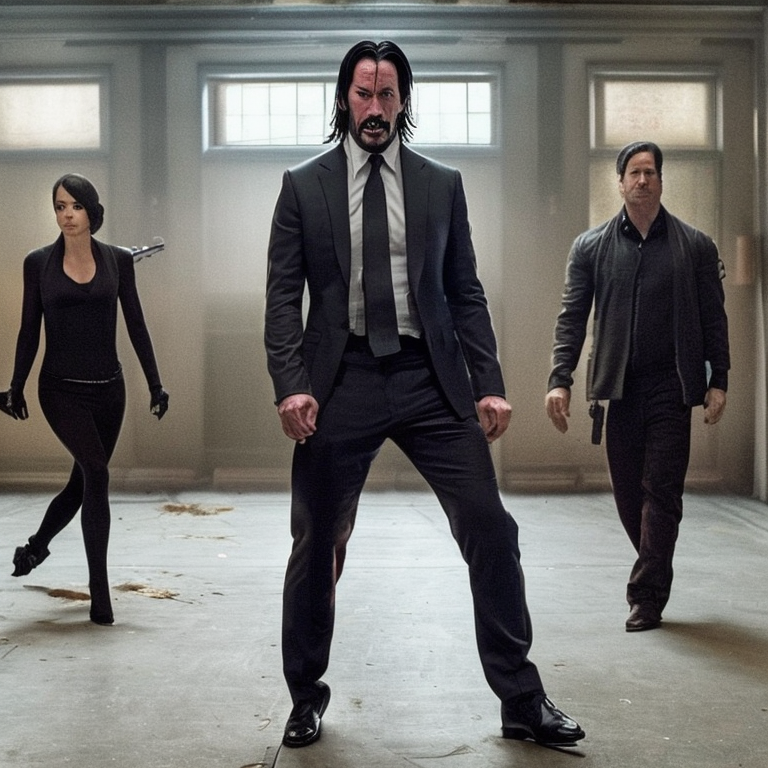

In [18]:
#We'll give your summary to the imagine generation
#If you run this cell again you'll get a different picture
image = pipe(random_summary).images[0]
display(image)

In [19]:
#Run this cell to save your image in your usual Google Drive folder
image.save(file_name+".png")
shutil.move(file_name+".png","/content/gdrive/MyDrive/LibraryJuicePython")

'/content/gdrive/MyDrive/LibraryJuicePython/Ballerina review.pdf.png'

# Imagine Generation, just for fun

I've created a [notebook](https://colab.research.google.com/drive/1Yp78vX9KQtpzo32b1vSWvoPKyksT7b_G?usp=sharing) that uses the Hugging Face Libraries to do image generation. Feel free to check it out, it might give you some ideas on how you can use generative AI with Python.


# On to the homework

We can use AI in our Colab Notebooks but we've discovered that we need to be a bit patient with letting the code run... It um, takes time.

Head over to the homework to try some more AI stuff.